In [1]:
from matplotlib import pyplot as plt
import pickle
import torch
import tqdm
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)

## Data reading

### clickstream

Defines listening events

In [13]:
from pathlib import Path
data_path = Path.home().joinpath('data/sberzvuk/ailab_data/')

clickstream = pd.read_csv(data_path.joinpath('clickstream.csv'), nrows=1_000_000)
clickstream.shape

(1000000, 6)

In [14]:
clickstream.columns

Index(['user_id', 'track_id', 'event_nm', 'action_nm',
       'playevent_play_duration', 'proc_dt'],
      dtype='object')

In [15]:
clickstream.head(5)

,user_id,track_id,event_nm,action_nm,playevent_play_duration,proc_dt
0,e90208b469c84a84c91d81d905028fed,55099089,playevent,NaN,18,2022-05-02
1,e90208b469c84a84c91d81d905028fed,15158288,playevent,NaN,299,2022-05-02
2,e90208b469c84a84c91d81d905028fed,64292273,playevent,NaN,307,2022-05-02
3,e90208b469c84a84c91d81d905028fed,53314945,playevent,NaN,665,2022-05-02
4,e90208b469c84a84c91d81d905028fed,5846537,playevent,NaN,406,2022-05-02


In [16]:
clickstream.rename(columns={'playevent_play_duration': 'dur_sec', 'proc_dt': 'event_dt'}, inplace=True)

In [17]:
clickstream.dur_sec.describe()

count    1000000.000000
mean         100.188872
std          103.286989
min           -1.000000
25%            3.000000
50%           71.000000
75%          187.000000
max         7365.000000
Name: dur_sec, dtype: float64

In [18]:
clickstream['event_nm'].unique()

array(['playevent', 'content_action_event'], dtype=object)

### user-track-score

Defines user-to-track scores

In [19]:
user_track_score = pd.read_csv(data_path.joinpath('user-track-score.csv'), nrows=1_000_000)
user_track_score.shape

(1000000, 3)

In [20]:
user_track_score.columns

Index(['user_id', 'track_id', 'score'], dtype='object')

In [21]:
user_track_score.sample(5)

,user_id,track_id,score
662518,6ed1dadc53ff81ac4b6646a713e41fe5,109535323,0.049340
274650,c6ea622888528db370dd727efc004c0b,77962856,0.703453
817440,44596dbe2de4a1c7fd33cf0170c9edfe,5863493,0.376226
642668,dc73a5cb6fd0a1743ca9ca085919e6a6,12791308,0.469947
389367,352ae8f466004bf32e4f3f50e3ea99ab,16677316,0.367778


In [22]:
user_track_score.score.describe()

count    1000000.000000
mean           0.305944
std            0.241200
min           -0.371067
25%            0.116889
50%            0.254101
75%            0.447083
max            1.524466
Name: score, dtype: float64

### track-content-embedding

Defines embeddings for tracks

In [30]:
track_content_embedding = pd.read_csv(data_path.joinpath('track-content-embedding.csv'), delimiter='|') #, nrows=1_000_000)
track_content_embedding.shape

(929571, 179)

In [33]:
track_content_embedding.columns

Index(['track_id', 'rock', 'pop', 'alternative', 'indie', 'electronic',
       'female vocalists', 'dance', '00s', 'alternative rock',
       ...
       'vggish_119', 'vggish_120', 'vggish_121', 'vggish_122', 'vggish_123',
       'vggish_124', 'vggish_125', 'vggish_126', 'vggish_127', 'vggish_128'],
      dtype='object', length=179)

In [34]:
track_content_embedding.sample(5)

,track_id,rock,pop,alternative,indie,electronic,female vocalists,dance,00s,alternative rock,...,vggish_119,vggish_120,vggish_121,vggish_122,vggish_123,vggish_124,vggish_125,vggish_126,vggish_127,vggish_128
536969,66005393,0.071554,0.306421,0.048542,0.054100,0.062061,0.325613,0.040742,0.021728,0.011157,...,0.543726,-0.208680,-0.185012,-0.134909,-0.438505,0.124369,0.138185,-0.637147,-0.017909,-0.003953
378883,45460100,0.036997,0.086162,0.024377,0.037385,0.426340,0.043818,0.300892,0.014645,0.006188,...,-0.018932,-0.024307,-0.110146,-0.035656,-0.343013,-0.059930,-0.018535,-0.596535,0.199394,-0.041864
167590,40281676,0.047446,0.318348,0.037440,0.046209,0.241585,0.165512,0.303018,0.021383,0.007285,...,0.365033,-0.148051,-0.103554,0.055882,-0.386947,0.043183,-0.092979,-0.699584,0.015895,-0.034829
536080,22485165,0.046817,0.218019,0.019299,0.020978,0.217206,0.088055,0.480829,0.011503,0.005262,...,0.111647,0.004004,-0.062023,0.046582,-0.394918,-0.043548,-0.041702,-0.630187,0.071891,-0.052904
641948,44134329,0.440288,0.061867,0.152635,0.115335,0.020610,0.040031,0.009992,0.025221,0.122237,...,0.589130,-0.188643,-0.302071,-0.186909,-0.365565,0.188420,-0.189164,-0.624328,0.219976,0.321445


### user-genre-embedding

Defines embeddings for users

In [23]:
user_genre_embedding = pd.read_csv(data_path.joinpath('user-genre-embedding.csv')) #, nrows=1_000_000)
user_genre_embedding.shape

(2662604, 66)

In [36]:
user_genre_embedding.columns

Index(['user_id', 'genre_1_cnt', 'genre_2_cnt', 'genre_3_cnt', 'genre_4_cnt',
       'genre_5_cnt', 'genre_6_cnt', 'genre_7_cnt', 'genre_8_cnt',
       'genre_9_cnt', 'genre_10_cnt', 'genre_11_cnt', 'genre_12_cnt',
       'genre_13_cnt', 'genre_14_cnt', 'genre_15_cnt', 'genre_16_cnt',
       'genre_17_cnt', 'genre_18_cnt', 'genre_19_cnt', 'genre_20_cnt',
       'genre_21_cnt', 'genre_22_cnt', 'genre_23_cnt', 'genre_24_cnt',
       'genre_25_cnt', 'genre_26_cnt', 'genre_27_cnt', 'genre_28_cnt',
       'genre_29_cnt', 'genre_30_cnt', 'genre_31_cnt', 'genre_32_cnt',
       'genre_33_cnt', 'genre_34_cnt', 'genre_35_cnt', 'genre_36_cnt',
       'genre_37_cnt', 'genre_38_cnt', 'genre_39_cnt', 'genre_40_cnt',
       'genre_41_cnt', 'genre_42_cnt', 'genre_43_cnt', 'genre_44_cnt',
       'genre_45_cnt', 'genre_46_cnt', 'genre_47_cnt', 'genre_48_cnt',
       'genre_49_cnt', 'genre_50_cnt', 'genre_51_cnt', 'genre_52_cnt',
       'genre_53_cnt', 'genre_54_cnt', 'genre_55_cnt', 'genre_56_cnt',
    

In [35]:
user_genre_embedding.sample(5)

,user_id,genre_1_cnt,genre_2_cnt,genre_3_cnt,genre_4_cnt,genre_5_cnt,genre_6_cnt,genre_7_cnt,genre_8_cnt,genre_9_cnt,...,genre_56_cnt,genre_57_cnt,genre_58_cnt,genre_59_cnt,genre_60_cnt,genre_61_cnt,genre_62_cnt,genre_63_cnt,genre_64_cnt,genre_65_cnt
1269919,6ff52026460cb8de54751f5f38e4832c,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
910296,cd2990c897e43d268bcb8437a9b6beb0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1780709,56346f101ab0d7d0e14d0f43e7d66a22,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
727129,0b91f9b2981d01c5631a6be05788e3cd,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
718565,20ce2166300bc09ef9e2646f858a291f,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
ailab = pd.read_csv(data_path.joinpath('ailab.csv'), nrows=1_000_000)
ailab.shape

(1000000, 7)

In [43]:
ailab.columns

Index(['user_id', 'packet_date', 'session_id', 'track_id', 'src_id',
       'event_name', 'playevent_play_duration'],
      dtype='object')

In [44]:
ailab.sample(5)

,user_id,packet_date,session_id,track_id,src_id,event_name,playevent_play_duration
280019,219F86D05C76364E1B212E85F66A4F0C,2022-04-12 14:38:35,2109757323,73253778,73253778,playevent,205
982791,C071C458AD9CB8B4235C031E77281A62,2022-04-17 22:34:56,-253572135,119584455,6498967,playevent,0
598716,AF3A7A766BFDECC636E6545D424421E8,2022-04-20 00:17:42,736824604,73226141,1062105,playevent,191
28432,5B91A90D5C2BFD6029159F2276A524C7,2022-04-26 22:07:23,-1581502475,114283196,1062105,playevent,1
992106,BA21D52CF37A902024E12782C4A87406,2022-04-27 06:03:33,-2058555095,87962394,6936835,playevent,190


## Extract very small subset

In [34]:
from pathlib import Path
data_path = Path.home().joinpath('data/sberzvuk/ailab_data/')

clickstream = pd.read_csv(data_path.joinpath('clickstream.csv'))
clickstream.shape

(144709347, 6)

In [35]:
clickstream.rename(columns={
    'playevent_play_duration': 'dur_sec', 'proc_dt': 'event_dt', 'event_nm': 'event', 'action_nm': 'action',
}, inplace=True)

In [36]:
clickstream.head(10)

,user_id,track_id,event,action,dur_sec,event_dt
0,e90208b469c84a84c91d81d905028fed,55099089,playevent,NaN,18,2022-05-02
1,e90208b469c84a84c91d81d905028fed,15158288,playevent,NaN,299,2022-05-02
2,e90208b469c84a84c91d81d905028fed,64292273,playevent,NaN,307,2022-05-02
3,e90208b469c84a84c91d81d905028fed,53314945,playevent,NaN,665,2022-05-02
4,e90208b469c84a84c91d81d905028fed,5846537,playevent,NaN,406,2022-05-02
5,e90208b469c84a84c91d81d905028fed,44296244,playevent,NaN,180,2022-05-02
6,e90208b469c84a84c91d81d905028fed,11453390,playevent,NaN,218,2022-05-02
7,e90208b469c84a84c91d81d905028fed,23740059,playevent,NaN,396,2022-05-02
8,e90208b469c84a84c91d81d905028fed,13032107,playevent,NaN,659,2022-05-02
9,e90208b469c84a84c91d81d905028fed,5508071,playevent,NaN,117,2022-05-02


In [37]:
clickstream.event.unique()

array(['playevent', 'content_action_event'], dtype=object)

In [198]:
clickstream.action.unique()

array([nan, 'LIKE', 'BLOCK_ITEM_ON'], dtype=object)

In [38]:
clickstream.event_dt.min(), clickstream.event_dt.max()

('2022-04-07', '2022-05-05')

In [39]:
clickstream.user_id.nunique()

813078

In [40]:
clickstream.track_id.nunique()

2399908

In [57]:
rng = np.random.default_rng(43)
ds = clickstream
users = rng.choice(ds.user_id.unique(), 1000)
users.shape

(1000,)

In [138]:
%%time

ds_small = ds[ds.user_id.isin(users)]
ds_small.reset_index(drop=True, inplace=True)
ds_small.shape

CPU times: user 2.19 s, sys: 467 ms, total: 2.65 s
Wall time: 3.01 s


(192749, 6)

In [139]:
ds_small.head(10)

,user_id,track_id,event,action,dur_sec,event_dt
0,c93f24e9efb2816c8a7fbe32cfdcafe0,16094882,playevent,NaN,4,2022-05-02
1,c93f24e9efb2816c8a7fbe32cfdcafe0,63311776,playevent,NaN,152,2022-05-02
2,c93f24e9efb2816c8a7fbe32cfdcafe0,71291041,playevent,NaN,160,2022-05-02
3,c93f24e9efb2816c8a7fbe32cfdcafe0,62530131,playevent,NaN,315,2022-05-02
4,c93f24e9efb2816c8a7fbe32cfdcafe0,54018220,playevent,NaN,284,2022-05-02
5,c93f24e9efb2816c8a7fbe32cfdcafe0,54018270,playevent,NaN,225,2022-05-02
6,c93f24e9efb2816c8a7fbe32cfdcafe0,47467110,playevent,NaN,308,2022-05-02
7,c93f24e9efb2816c8a7fbe32cfdcafe0,74874065,playevent,NaN,245,2022-05-02
8,c93f24e9efb2816c8a7fbe32cfdcafe0,64264942,playevent,NaN,231,2022-05-02
9,c93f24e9efb2816c8a7fbe32cfdcafe0,63301745,playevent,NaN,106,2022-05-02


In [64]:
ds_small.user_id.nunique(), ds_small.track_id.nunique(), ds_small.event_dt.min(), ds_small.event_dt.max()

(1000, 34388, '2022-04-07', '2022-05-05')

<AxesSubplot: ylabel='Count'>

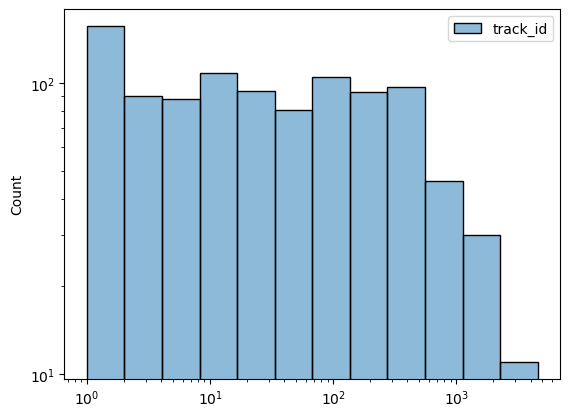

In [94]:
sns.histplot(
    ds_small[['user_id', 'track_id']].groupby(['user_id']).aggregate(['count']), log_scale=(True, True)
)

In [111]:
cnts = ds_small[['user_id', 'track_id']].groupby(['user_id']).aggregate(['count'])
cnts.track_id['count']

user_id
004282410a524fa43939efbc98f4cef8      3
004355c17608bf9a4f9a277b6e68ab07     95
0056f22bf74d20805e9ac8ee42a07c24      1
00964c3a6222e01418047857cc30b55b     11
00d203480c12718f5609a26ff16686c8      1
                                   ... 
feff7bd44947ee752ac78d36e474fdb2    353
ff5aaf4e8d6063a977c03ecd0da06826      2
ff73281ce7c2a55e05e150c1db0ae2c4     71
ff942390077474a744b37dce5d5243ea     40
ffcb970ac0c27dc1d08f111f041cc672     88
Name: count, Length: 1000, dtype: int64

<AxesSubplot: ylabel='Count'>

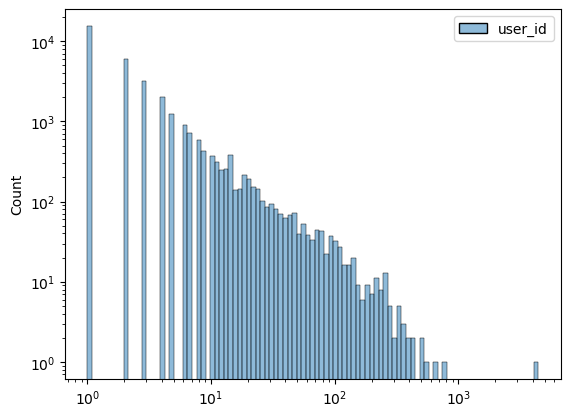

In [93]:
sns.histplot(
    ds_small[['user_id', 'track_id']].groupby(['track_id']).aggregate(['count']), log_scale=(True, True)
)

In [101]:
cnts = ds_small[['user_id', 'track_id']].groupby(['track_id']).aggregate(['count']).values.flatten()
np.count_nonzero(cnts < 5)

26796

In [118]:
ds_small[ds_small.event == 'content_action_event']

,user_id,track_id,event,action,dur_sec,event_dt
207999,5156fed06ec82ed93eac560014effb13,55089677,content_action_event,LIKE,-1,2022-05-04
238289,4cc08a591fff29be3bec3ce29c785c35,119984448,content_action_event,LIKE,-1,2022-05-05
238290,4cc08a591fff29be3bec3ce29c785c35,119984448,content_action_event,LIKE,-1,2022-05-05
238291,4cc08a591fff29be3bec3ce29c785c35,119934317,content_action_event,LIKE,-1,2022-05-05
238292,4cc08a591fff29be3bec3ce29c785c35,119966587,content_action_event,LIKE,-1,2022-05-05
...,...,...,...,...,...,...
144616023,0b3b512c7a694efa26d33fa8ff453252,119417949,content_action_event,LIKE,-1,2022-04-08
144634088,8b70d5a3d9831f9fba45e12b780c759c,50001839,content_action_event,LIKE,-1,2022-04-07
144634146,8b70d5a3d9831f9fba45e12b780c759c,93010217,content_action_event,LIKE,-1,2022-04-07
144706776,5ea9208f2970251e4c941bb3a4bd8b57,91166879,content_action_event,LIKE,-1,2022-04-08


In [137]:
ds_small.reset_index(drop=True, inplace=True)

,level_0,index,user_id,track_id,event,action,dur_sec,event_dt
0,0,44202,c93f24e9efb2816c8a7fbe32cfdcafe0,16094882,playevent,NaN,4,2022-05-02
1,1,44203,c93f24e9efb2816c8a7fbe32cfdcafe0,63311776,playevent,NaN,152,2022-05-02
2,2,44204,c93f24e9efb2816c8a7fbe32cfdcafe0,71291041,playevent,NaN,160,2022-05-02
3,3,44205,c93f24e9efb2816c8a7fbe32cfdcafe0,62530131,playevent,NaN,315,2022-05-02
4,4,44206,c93f24e9efb2816c8a7fbe32cfdcafe0,54018220,playevent,NaN,284,2022-05-02
...,...,...,...,...,...,...,...,...
192744,192744,144707024,5ea9208f2970251e4c941bb3a4bd8b57,59167165,playevent,NaN,10,2022-04-08
192745,192745,144707025,5ea9208f2970251e4c941bb3a4bd8b57,59167170,playevent,NaN,27,2022-04-08
192746,192746,144707026,5ea9208f2970251e4c941bb3a4bd8b57,59167166,playevent,NaN,2,2022-04-08
192747,192747,144707027,5ea9208f2970251e4c941bb3a4bd8b57,59167164,playevent,NaN,213,2022-04-08


In [164]:
user_track_score = pd.read_csv(data_path.joinpath('user-track-score.csv'))

In [165]:
user_track_score.head(10)

,user_id,track_id,score
0,bc4ae6fc3f10c84061fa624fbf05764c,90965391,0.057314
1,e8443a4a6cc0340100934cf473f7bcef,90965391,0.030714
2,2303d09d777fbef2f362db3354fe83f7,90965391,0.161742
3,3154279c1278d3053f3cf702cf867211,90965391,0.091410
4,d410e5ab0887c4609bd6362b9f9aa9c3,90965391,0.261495
5,a0dbb72054d3c17e7198b5a717db1e66,90965391,0.227424
6,62d0d196b8ebd1f1e536e7889814a6d2,90965391,0.165035
7,9a95b5881d5e87d44be73779011cb217,90965391,0.466040
8,0626a7ad0711444acddb9f71a9464730,90965391,0.053395
9,22896d41f78a9a9d798aeecf07e1c128,90965391,0.099732


In [166]:
user_track_score.set_index('user_id', inplace=True)

In [168]:
user_track_score.head(2)

,track_id,score
user_id,,
bc4ae6fc3f10c84061fa624fbf05764c,90965391,0.057314
e8443a4a6cc0340100934cf473f7bcef,90965391,0.030714


In [169]:
scores = user_track_score[user_track_score.index.isin(users)]

In [172]:
scores.reset_index(level=0, inplace=True)

In [173]:
scores.set_index(['user_id', 'track_id'], inplace=True)

In [175]:
ds_small.join(scores, on=['user_id', 'track_id'])

,user_id,track_id,event,action,dur_sec,event_dt,score
0,c93f24e9efb2816c8a7fbe32cfdcafe0,16094882,playevent,NaN,4,2022-05-02,NaN
1,c93f24e9efb2816c8a7fbe32cfdcafe0,63311776,playevent,NaN,152,2022-05-02,0.535788
2,c93f24e9efb2816c8a7fbe32cfdcafe0,71291041,playevent,NaN,160,2022-05-02,NaN
3,c93f24e9efb2816c8a7fbe32cfdcafe0,62530131,playevent,NaN,315,2022-05-02,0.729073
4,c93f24e9efb2816c8a7fbe32cfdcafe0,54018220,playevent,NaN,284,2022-05-02,NaN
...,...,...,...,...,...,...,...
192744,5ea9208f2970251e4c941bb3a4bd8b57,59167165,playevent,NaN,10,2022-04-08,NaN
192745,5ea9208f2970251e4c941bb3a4bd8b57,59167170,playevent,NaN,27,2022-04-08,NaN
192746,5ea9208f2970251e4c941bb3a4bd8b57,59167166,playevent,NaN,2,2022-04-08,NaN
192747,5ea9208f2970251e4c941bb3a4bd8b57,59167164,playevent,NaN,213,2022-04-08,NaN


In [178]:
ds_small = ds_small.copy()

In [194]:
ds_small['rating'] = 3.0

In [199]:
ds_small.loc[ds_small.action == 'BLOCK_ITEM_ON', 'rating'] = 1.0
ds_small.loc[ds_small.action == 'LIKE', 'rating'] = 5.0

In [200]:
ds_small.head(5)

,user_id,track_id,event,action,dur_sec,event_dt,rating
0,c93f24e9efb2816c8a7fbe32cfdcafe0,16094882,playevent,NaN,4,2022-05-02,3.0
1,c93f24e9efb2816c8a7fbe32cfdcafe0,63311776,playevent,NaN,152,2022-05-02,3.0
2,c93f24e9efb2816c8a7fbe32cfdcafe0,71291041,playevent,NaN,160,2022-05-02,3.0
3,c93f24e9efb2816c8a7fbe32cfdcafe0,62530131,playevent,NaN,315,2022-05-02,3.0
4,c93f24e9efb2816c8a7fbe32cfdcafe0,54018220,playevent,NaN,284,2022-05-02,3.0


In [202]:
ds_small['item_id'] = ds_small['track_id']
ds_small['timestamp'] = ds_small['event_dt']

In [208]:
ds_ratings = ds_small[['user_id', 'item_id', 'timestamp', 'rating']]
ds_ratings.head(3)

,user_id,item_id,timestamp,rating
0,c93f24e9efb2816c8a7fbe32cfdcafe0,16094882,2022-05-02,3.0
1,c93f24e9efb2816c8a7fbe32cfdcafe0,63311776,2022-05-02,3.0
2,c93f24e9efb2816c8a7fbe32cfdcafe0,71291041,2022-05-02,3.0


In [209]:
cache_path = data_path.parent / 'cache'
ds_ratings.to_csv(cache_path / 'ratings.csv')